# Daymet data
Calculate mean and stdev by month of monthly daymet summaries for North America over 40 years (1980-2019 inclusive)

In [1]:
import math
import os
import time

# pip/conda installed
import dask.array as da
import fsspec
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from dask.distributed import as_completed
from dask.distributed import Client
from dask.distributed import performance_report
from dask_gateway import GatewayCluster

from utils import get_logger
from utils.dask import create_cluster
from utils.dask import upload_source

In [2]:
# fill with your account key
os.environ['AZURE_ACCOUNT_KEY'] = ""

In [3]:
num_workers = 64
cluster = create_cluster(
    workers=num_workers,
    worker_threads=1,
    worker_memory=8,
    scheduler_threads=4,
    scheduler_memory=8
)
client = cluster.get_client()
upload_source('./utils', client)
cluster

In [4]:
src = fsspec.get_mapper(
    "az://daymet-zarr/monthly/na.zarr",
    account_name="daymeteuwest",
)

ds = xr.open_zarr(src, consolidated=True, chunks={'time': 1, 'x': 1250, 'y': 1250})[["prcp", "swe", "tmax", "tmin", "vp"]]
print(ds.nbytes / 1000000000)
ds

606.246131796


<xarray.Dataset>
Dimensions:  (time: 480, x: 7814, y: 8075)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-16T12:00:00 ... 2019-12-16T12:00:00
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Data variables:
    prcp     (time, y, x) float32 dask.array<chunksize=(12, 1250, 1250), meta=np.ndarray>
    swe      (time, y, x) float32 dask.array<chunksize=(12, 1250, 1250), meta=np.ndarray>
    tmax     (time, y, x) float32 dask.array<chunksize=(12, 1250, 1250), meta=np.ndarray>
    tmin     (time, y, x) float32 dask.array<chunksize=(12, 1250, 1250), meta=np.ndarray>
    vp       (time, y, x) float32 dask.array<chunksize=(12, 1250, 1250), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        [1980]

In [5]:
mean_dest = fsspec.get_mapper(
    f"az://fia/daymet/na_40yr_monthly_means.zarr",
    account_name="usfs",
    account_key=os.environ['AZURE_ACCOUNT_KEY']
)
std_dest = fsspec.get_mapper(
    f"az://fia/daymet/na_40yr_monthly_std_devs.zarr",
    account_name="usfs",
    account_key=os.environ['AZURE_ACCOUNT_KEY']
)

In [6]:
mean = ds.groupby('time.month').mean()
print(mean.nbytes/1000000000)
mean

15.648380052


<xarray.Dataset>
Dimensions:  (month: 12, x: 7814, y: 8075)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prcp     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    swe      (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    tmax     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    tmin     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    vp       (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>

In [7]:
std = ds.groupby('time.month').std()
print(mean.nbytes/1000000000)
std

15.648380052


<xarray.Dataset>
Dimensions:  (month: 12, x: 7814, y: 8075)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prcp     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    swe      (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    tmax     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    tmin     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    vp       (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>

In [8]:
mean.to_zarr(mean_dest)

In [9]:
std.to_zarr(std_dest)

In [18]:
mn = xr.open_zarr(mean_dest)
mn

<xarray.Dataset>
Dimensions:  (month: 12, x: 7814, y: 8075)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(505, 977), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Data variables:
    prcp     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    swe      (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    tmax     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    tmin     (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    vp       (month, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>

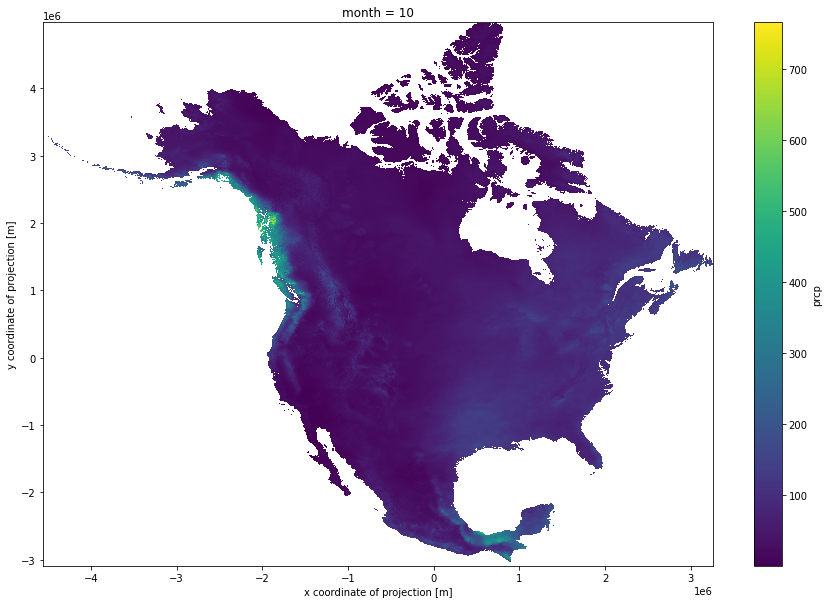

In [19]:
mn['prcp'].sel(month=10).plot.imshow(size=10)

In [20]:
cluster.shutdown()